## Import Modules

In [0]:
# !pip install graphviz
# !pip install torchviz

In [0]:
import random
import time
import pandas as pd
import numpy as np

from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.data import BucketIterator, Iterator
from torchtext import data
from torchtext import datasets


import torch
import torch.nn as nn
import torch.optim as optim

# import torchviz as viz

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
SEED = 479

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# !CUDA_LAUNCH_BLOCKING=0

In [0]:
STOPWORDS = set(stopwords.words('english'))

## Preparing Data

In [6]:
# read in data
path = '4_19_lyrics_with_tags.csv'
ly = pd.read_csv(path, delimiter = ",", dtype = {'lyrics':str})
ly.head(3)

,artist,title,language,lyrics,track_id,tags,category
0,Lena Philipsson,006,1.0,I had come in the name of love\nWith a mission...,TRMMMKI128F931D80D,pop,2
1,Shawn Colvin,The Heart Of Saturday,1.0,Well you gassed her up\nBehind the wheel\nWith...,TRQFODA128F93319C3,pop,2
2,Dying Fetus,Ethos of Coercion,1.0,"Castigation of the offenders, no punishment ou...",TRLXQQL128F4291A8F,rock,1


In [0]:
# declare field

TEXT = Field(sequential=True, tokenize='spacy', lower=True,
             stop_words = STOPWORDS, include_lengths=True)

LABEL = Field(sequential=False, use_vocab=True, is_target=True)

In [0]:
# setup dataset

trn_vld_tst_fields = [("artist", None), ("title", None), ("language", None),
                      ("lyrics", TEXT), ("track_id", None), ("tags", LABEL)]

trn_vld_tst_dataset = TabularDataset(
    path="4_19_lyrics_with_tags.csv", format='csv',
    skip_header=True, fields=trn_vld_tst_fields)

In [9]:
# split dataset into trn, tst, vld
# with ratio: 6, 3, 1
# use random.seed

trn, vld, tst = trn_vld_tst_dataset.split(
    split_ratio = [0.6, 0.3, 0.1],
    random_state = random.seed(SEED))

print('Number of training examples:', len(trn), sep = ' ')
print('Number of validation examples:', len(vld), sep = ' ')
print('Number of testing examples:', len(tst), sep = ' ')

Number of training examples: 46731
Number of validation examples: 7788
Number of testing examples: 23366


In [10]:
# setup dictionary on train dataset
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(trn, max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(trn)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 7


In [11]:
LABEL.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'<unk>': 0,
             'alternative': 5,
             'dance': 6,
             'indie': 3,
             'others': 4,
             'pop': 2,
             'rock': 1})

In [12]:
LABEL.vocab.freqs

Counter({'alternative': 1301,
         'dance': 1017,
         'indie': 1911,
         'others': 1829,
         'pop': 5885,
         'rock': 34788})

In [0]:
# create iterators
BATCH_SIZE = 64

trn_iter, vld_iter, tst_iter = BucketIterator.splits(
    (trn, vld, tst), device = device,
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key=lambda x: len(x.lyrics))

## Build the Model

In [0]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))

* input_dim = the dimension of the one-hot vectors = vocabulary size

* embedding_dim = size of the dense word vectors = 50~250, depending on input_dim

* hidden_dim = size of the hidden states = 100~500, depending on input_dim, embedding_dim, complexity of the task

* output_dim = number of classes

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 7
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [89]:
def count_trnable_para(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_trnable_para(model):,} trainable parameters')

The model has 3,132,783 trainable parameters


In [90]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [91]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.9096,  0.3123,  0.9969,  ..., -0.0807, -1.1631, -0.5760],
        [-0.9990,  0.5651, -0.1949,  ..., -1.2643,  0.6189, -0.1765],
        [-2.3781,  0.0426,  1.3485,  ...,  1.4875, -0.5941,  1.8406],
        ...,
        [ 0.0682, -0.4873, -0.2402,  ...,  0.3613, -0.1153, -0.0922],
        [ 0.6267, -0.3694,  0.0572,  ..., -0.6375, -0.6051,  0.4741],
        [ 0.0038, -1.3533, -0.0416,  ...,  0.1305,  0.6898,  0.6697]])

In [92]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.3781,  0.0426,  1.3485,  ...,  1.4875, -0.5941,  1.8406],
        ...,
        [ 0.0682, -0.4873, -0.2402,  ...,  0.3613, -0.1153, -0.0922],
        [ 0.6267, -0.3694,  0.0572,  ..., -0.6375, -0.6051,  0.4741],
        [ 0.0038, -1.3533, -0.0416,  ...,  0.1305,  0.6898,  0.6697]])


## Train the Model

In [0]:
def weighted_loss_byfreq(vocab):
  '''get the weights of class labels in CrossEntropyLoss
  weight.vec[0] is for class <unk> '''
  weight_vec = torch.zeros(len(vocab.stoi))
  freqs = torch.tensor( list( vocab.freqs.values() ) )
  
  weight_vec[1:] = freqs.max() / freqs
  weight_vec[0] = weight_vec[1:].min()
  
  return(weight_vec)

In [0]:
# define optimizer
optimizer = optim.Adam(model.parameters())

# define loss function
weight_by_class = weighted_loss_byfreq(LABEL.vocab)
criterion = nn.CrossEntropyLoss(weight=weight_by_class)

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def multiclass_accuracy(model_output, y):
    model_preds = torch.sigmoid(model_output).max(1)[1]
    correct = (model_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [0]:
# define train function
  
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # model.train(): put the model in "training mode"
    # which turns on dropout and batch normalization.
    model.train()
    
    for batch in iterator:
        
        # zero the gradients
        # PyTorch does not automatically remove (zero) the gradients
        # of the last gradient calculation
        optimizer.zero_grad()
        
        text, text_lengths = batch.lyrics
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.tags)
        
        acc = multiclass_accuracy(predictions, batch.tags)
        
        # update model's parameters
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
# define evaluate function
# similar to train, but don't want update parameters
  
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # model.eval(): puts the model in "evaluation mode"
    # which turns off dropout and batch normalization
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.lyrics
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.tags)
            
            acc = multiclass_accuracy(predictions, batch.tags)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
# tell us how long an epoch takes
# to compare training times between models.

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
def get_preds(model, iterator, data):
  'data is the original of iterator'
  
  preds = torch.zeros(len(data))
  pointer = 0
  
  model.eval()
    
  with torch.no_grad():
    for batch in iterator:
      text, text_lengths = batch.lyrics
      model_output = model(text, text_lengths).squeeze(1)
      model_preds = torch.sigmoid(model_output).max(1)[1]
      preds[pointer:(pointer+len(batch))] = model_preds
      pointer += len(batch)
   
  return(preds)

In [100]:
N_EPOCHS = 70

best_valid_loss = float('inf')

best_valid_acc = 0.0

epoch_train_loss = []
epoch_train_acc = []
epoch_vld_loss = []
epoch_vld_acc = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    trn_loss, trn_acc = train(model, trn_iter, optimizer, criterion)
    vld_loss, vld_acc = evaluate(model, vld_iter, criterion)
    
    epoch_train_loss.append(trn_loss)
    epoch_train_acc.append(trn_acc)
    epoch_vld_loss.append(vld_loss)
    epoch_vld_acc.append(vld_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if vld_acc > best_valid_acc:
        best_valid_acc = vld_acc
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {trn_loss:.3f} | Train Acc: {trn_acc*100:.2f}%')
    print(f'\t Val. Loss: {vld_loss:.3f} |  Val. Acc: {vld_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 43s
	Train Loss: 1.758 | Train Acc: 4.94%
	 Val. Loss: 1.719 |  Val. Acc: 4.13%
Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 1.714 | Train Acc: 5.57%
	 Val. Loss: 1.713 |  Val. Acc: 4.55%
Epoch: 03 | Epoch Time: 0m 42s
	Train Loss: 1.664 | Train Acc: 8.07%
	 Val. Loss: 1.689 |  Val. Acc: 6.86%
Epoch: 04 | Epoch Time: 0m 42s
	Train Loss: 1.604 | Train Acc: 10.43%
	 Val. Loss: 1.697 |  Val. Acc: 6.49%
Epoch: 05 | Epoch Time: 0m 42s
	Train Loss: 1.528 | Train Acc: 13.64%
	 Val. Loss: 1.809 |  Val. Acc: 6.66%
Epoch: 06 | Epoch Time: 0m 42s
	Train Loss: 1.439 | Train Acc: 19.48%
	 Val. Loss: 1.786 |  Val. Acc: 9.83%
Epoch: 07 | Epoch Time: 0m 42s
	Train Loss: 1.352 | Train Acc: 22.75%
	 Val. Loss: 1.854 |  Val. Acc: 18.58%
Epoch: 08 | Epoch Time: 0m 42s
	Train Loss: 1.275 | Train Acc: 28.55%
	 Val. Loss: 1.915 |  Val. Acc: 31.01%
Epoch: 09 | Epoch Time: 0m 42s
	Train Loss: 1.179 | Train Acc: 31.51%
	 Val. Loss: 2.026 |  Val. Acc: 24.20%
Epoch: 10 | Epoch Time: 0m 4

In [0]:
# model.load_state_dict(torch.load('tut1-model.pt'))

# N_EPOCHS = 30

# for epoch in range(N_EPOCHS):

#     start_time = time.time()
    
#     trn_loss, trn_acc = train(model, trn_iter, optimizer, criterion)
#     vld_loss, vld_acc = evaluate(model, vld_iter, criterion)
    
#     end_time = time.time()

#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if vld_loss < best_valid_loss:
#         best_valid_loss = vld_loss
#         torch.save(model.state_dict(), 'tut1-model.pt')
    
#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {trn_loss:.3f} | Train Acc: {trn_acc*100:.2f}%')
#     print(f'\t Val. Loss: {vld_loss:.3f} |  Val. Acc: {vld_acc*100:.2f}%')

In [102]:
# model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, tst_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 7.918 | Test Acc: 54.71%


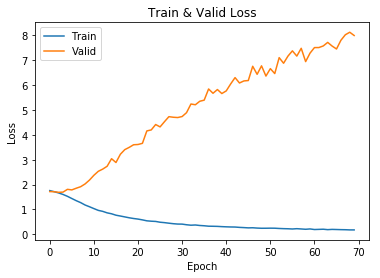

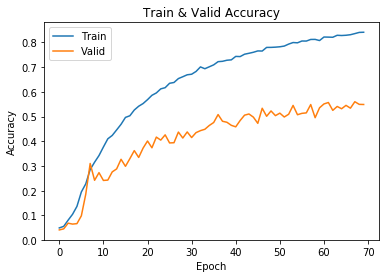

In [103]:
plt.plot(range(len(epoch_train_loss)), epoch_train_loss)
plt.plot(range(len(epoch_vld_loss)), epoch_vld_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Train & Valid Loss')
plt.legend(['Train', 'Valid'])
plt.show()



plt.plot(range(len(epoch_train_acc)), epoch_train_acc)
plt.plot(range(len(epoch_vld_acc)), epoch_vld_acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Train & Valid Accuracy')
plt.legend(['Train', 'Valid'])
plt.show()

In [0]:
preds_trn = get_preds(model, tst_iter, tst)

In [105]:
print(np.histogram(np.array(preds_trn)))
preds_trn[:5]

(array([15038,     0,  4377,     0,  1066,     0,  1602,     0,   566,
         717]), array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ],
      dtype=float32))


tensor([4., 4., 4., 1., 3.])

(1, 6)

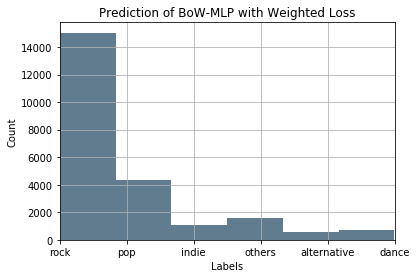

In [106]:
preds_trn_pd = pd.Series(preds_trn)
preds_trn_pd.plot.hist(grid=True, bins=6, rwidth=5, color='#607c8e')

plt.title('Prediction of BoW-MLP with Weighted Loss')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.grid(axis='y', alpha=1)

label_num = range(1, 7)
label_text = ['rock', 'pop', 'indie', 'others', 'alternative', 'dance']
plt.xticks(label_num, label_text)

plt.xlim(1, 6)

In [0]:
import pickle

with open("plot.txt", "wb") as fp:   #Pickling
  pickle.dump(epoch_train_loss, fp)
  pickle.dump(epoch_train_acc, fp)
  pickle.dump(epoch_vld_loss, fp)
  pickle.dump(epoch_vld_acc, fp)



In [0]:
with open("plot.txt", "rb") as fp:   # Unpickling
  b = pickle.load(fp)

In [111]:
len(b)

70

In [0]:
df_save = pd.DataFrame({'1': epoch_train_loss, '2': epoch_train_acc, '3': epoch_vld_loss, '4': epoch_vld_acc})

In [0]:
df_save.to_csv('Train_record.csv', index = False)